<a href="https://colab.research.google.com/github/dawud-shakir/prof_trilce_notebooks/blob/main/pytorch_lightning_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTE: With pytorch lighning you can easily change the runtime engine. In the top menu, go `Runtime`, then `change runtime type` you may not see much improvement with this data, because it is small. But with larger datasets you will definitely see performance improvements


In [ ]:
!pip install pytorch_lightning
!pip install torchviz
!pip install torchview

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 12.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

class MLP(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.cost = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def evaluate(self, batch, stage=None):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.cost(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        if stage:
            self.log(f"{stage}_loss", loss, on_epoch=True, prog_bar=True, logger=True) #
            self.log(f"{stage}_acc", acc,  on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return(self.evaluate(batch, "train"))

    def validation_step(self, batch, batch_idx):
        return(self.evaluate(batch, "val"))

    def test_step(self, batch, batch_idx):
        return(self.evaluate(batch, "test"))

    def on_train_epoch_end(self):
        print(f"Train Loss: {self.trainer.callback_metrics['train_loss'].item()}, Train Accuracy: {100 * self.trainer.callback_metrics['train_acc'].item():.2f}%")

    def on_validation_epoch_end(self):
        print(f"Validation Loss: {self.trainer.callback_metrics['val_loss'].item()}, Validation Accuracy: {100 * self.trainer.callback_metrics['val_acc'].item():.2f}%")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001, weight_decay=0.01)
        return optimizer


# Load and preprocess data
wine = load_wine()
X, y = wine.data, wine.target
scaler = StandardScaler()

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train = scaler.fit_transform(X_train)
X_test_val = scaler.transform(X_test_val)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42, stratify=y_test_val)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize MLP model
input_size = X_train.shape[1]
hidden_size = 64
output_size = len(np.unique(y_train))  # Number of classes

model = MLP(input_size, hidden_size, output_size)
print(model)

# Train the model using PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=10,logger=CSVLogger(save_dir="logs/"))
trainer.fit(model, train_loader, val_loader)

# Test the model
test1 = trainer.test(model, dataloaders=test_loader)





INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | fc1     | Linear           | 896   
1 | fc2     | Linear           | 195   
2 | dropout | Dropout          | 0     
3 | relu    | ReLU             | 0     
4 | cost    | CrossEntropyLoss | 0     
---------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


MLP(
  (fc1): Linear(in_features=13, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (cost): CrossEntropyLoss()
)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation Loss: 1.1522096395492554, Validation Accuracy: 27.78%


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss: 1.0739041566848755, Validation Accuracy: 27.78%
Train Loss: 1.1285450458526611, Train Accuracy: 30.28%


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss: 1.0001330375671387, Validation Accuracy: 33.33%
Train Loss: 1.031341791152954, Train Accuracy: 39.44%


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss: 0.9306151270866394, Validation Accuracy: 61.11%
Train Loss: 0.9720631837844849, Train Accuracy: 50.00%


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss: 0.8657267093658447, Validation Accuracy: 77.78%
Train Loss: 0.9067375063896179, Train Accuracy: 69.01%


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss: 0.8060601353645325, Validation Accuracy: 88.89%
Train Loss: 0.8304884433746338, Train Accuracy: 83.80%


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss: 0.7502860426902771, Validation Accuracy: 94.44%
Train Loss: 0.7644472718238831, Train Accuracy: 88.73%


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss: 0.6970325708389282, Validation Accuracy: 94.44%
Train Loss: 0.7247887849807739, Train Accuracy: 89.44%


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss: 0.6473754048347473, Validation Accuracy: 94.44%
Train Loss: 0.6555560231208801, Train Accuracy: 92.96%


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss: 0.5997902154922485, Validation Accuracy: 94.44%
Train Loss: 0.6163545250892639, Train Accuracy: 94.37%


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Validation Loss: 0.5549527406692505, Validation Accuracy: 94.44%
Train Loss: 0.555031418800354, Train Accuracy: 95.77%


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8888888955116272     │
│         test_loss         │    0.49023744463920593    │
└───────────────────────────┴───────────────────────────┘

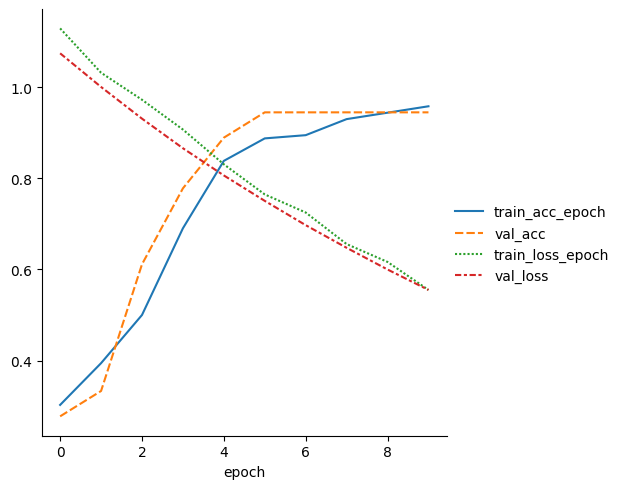

In [ ]:
# Plot the logs

import pandas as pd
import seaborn as sn

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
#print(metrics.head())
sn.relplot(data=metrics[['train_acc_epoch','val_acc','train_loss_epoch','val_loss']], kind="line")

## Visualize the Network

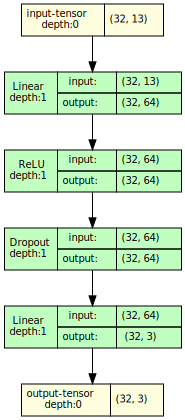

In [ ]:
# visualize network architecture

from torchview import draw_graph

# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(batch_size, input_size), device='meta')
model_graph.visual_graph

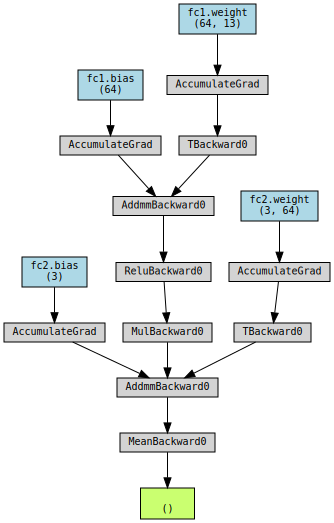

In [ ]:
# visualize the propagation of gradients

from torchviz import make_dot

X,Y = next(iter(test_loader))
device = next(model.parameters()).device
X = X.to(device)
yhat = model(X)

make_dot(yhat.mean(), params=dict(model.named_parameters()))
